# Emotion Analysis with NLP

In this notebook, we will perform an emotion analysis using Natural Language Processing (NLP) techniques. We will use the NLTK and Spacy libraries to preprocess the text data, and then we will implement machine learning models from the Scikit-learn library to classify the emotions.

## Importing Libraries

First, we import the necessary libraries.

In [2]:
import pandas as pd
import spacy
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

/home/thomas59/anaconda3/envs/machine-learning/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Loading the Data

We load the emotion dataset and check the distribution of emotions.

In [3]:
df = pd.read_csv('../data/Emotion_final.csv')
emotion_distribution = df['Emotion'].value_counts()
print(emotion_distribution)

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64


## Preprocessing the Text Data

We will define a function `process` to perform several preprocessing steps:
- Remove punctuation
- Remove stopwords
- Tokenize the text

In [4]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

custom_stopwords = ['nt', 'm', 's', 't', 've' , 'feel', 'feeling' , 'feelings' , 'like' , 'know' , 'want' , 'time' , 'think' , 'little']
stop_words = stop_words.union(custom_stopwords)

def remove_stopwords(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

def process(text):
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text

df['Text'] = df['Text'].apply(process)


## Most Common Words for Each Emotion

We identify the 30 most common words for each emotion, excluding stopwords.

In [5]:
def get_most_common_words(texts, num_words):
    words = [word for text in texts for word in text.split() if word not in stop_words]
    return Counter(words).most_common(num_words)

for emotion in df['Emotion'].unique():
    texts = df[df['Emotion'] == emotion]['Text']
    print(f'{emotion}: {get_most_common_words(texts, 30)}')


sadness: [('life', 228), ('people', 226), ('bit', 220), ('things', 194), ('day', 177), ('going', 164), ('way', 162), ('don', 155), ('pretty', 146), ('right', 143), ('love', 137), ('felt', 136), ('sad', 130), ('bad', 126), ('today', 125), ('depressed', 123), ('need', 121), ('work', 121), ('good', 121), ('having', 110), ('days', 110), ('miserable', 108), ('kind', 101), ('lost', 101), ('feels', 99), ('home', 99), ('left', 99), ('look', 98), ('help', 97), ('sorry', 97)]
anger: [('people', 149), ('angry', 116), ('things', 105), ('bit', 103), ('way', 102), ('don', 93), ('offended', 92), ('resentful', 87), ('cold', 86), ('irritable', 84), ('going', 81), ('bothered', 81), ('greedy', 77), ('life', 74), ('mad', 74), ('insulted', 73), ('irritated', 72), ('need', 71), ('pissed', 71), ('violent', 70), ('annoyed', 70), ('hated', 70), ('dissatisfied', 68), ('fucked', 68), ('rude', 68), ('right', 67), ('bitchy', 67), ('cranky', 67), ('frustrated', 66), ('rushed', 66)]
love: [('love', 119), ('sweet', 8

## Proximity Metric Between Emotions

We define a proximity metric between the emotions based on the 30 most common words and display it on a heatmap.

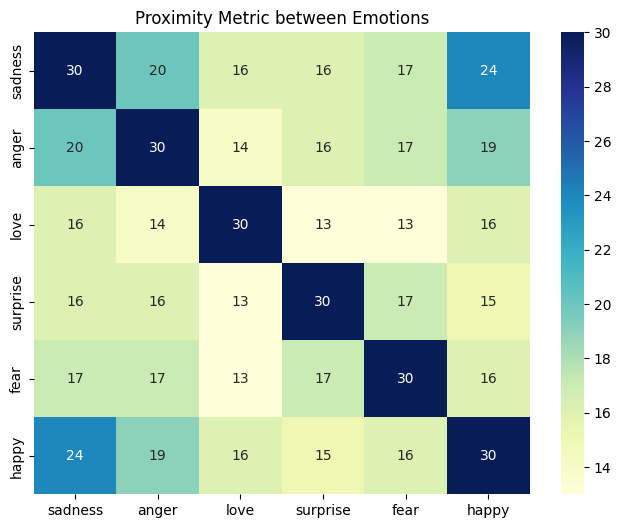

In [14]:
# Define the list of emotions
emotions = df['Emotion'].unique()

# Create an empty similarity matrix
similarity_matrix = pd.DataFrame(0, index=emotions, columns=emotions)

# Calculate the proximity metric based on common words
for emotion1 in emotions:
    for emotion2 in emotions:
        common_words = set([word for word, _ in get_most_common_words(df[df['Emotion'] == emotion1]['Text'], 30)]).intersection([word for word, _ in get_most_common_words(df[df['Emotion'] == emotion2]['Text'], 30)])
        similarity_matrix.loc[emotion1, emotion2] = len(common_words)

# Plot the similarity matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu")
plt.title("Proximity Metric between Emotions")
plt.show()

## Bag of Words Model

We create a Bag of Words model using a logistic regression classifier.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Emotion'], test_size=0.33, random_state=42)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       anger       0.89      0.88      0.89       993
        fear       0.85      0.84      0.84       871
       happy       0.94      0.90      0.92      2279
        love       0.75      0.93      0.83       550
     sadness       0.94      0.90      0.92      2110
    surprise       0.66      0.88      0.76       279

    accuracy                           0.89      7082
   macro avg       0.84      0.89      0.86      7082
weighted avg       0.90      0.89      0.89      7082



## TF-IDF Model

We create a TF-IDF model using a logistic regression classifier.


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pickle

# Supposons que df est votre DataFrame et qu'il contient deux colonnes : 'Text' et 'Emotion'
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Emotion'], test_size=0.33, random_state=42)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Enregistrer le modèle dans un fichier pickle
with open('../model/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Enregistrer le vectorizer dans un fichier pickle
with open('../model/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       anger       0.88      0.89      0.88       993
        fear       0.85      0.84      0.84       871
       happy       0.93      0.88      0.91      2279
        love       0.73      0.93      0.82       550
     sadness       0.94      0.89      0.91      2110
    surprise       0.66      0.89      0.75       279

    accuracy                           0.88      7082
   macro avg       0.83      0.89      0.85      7082
weighted avg       0.89      0.88      0.89      7082



## Predicting Emotion for a New Text

We use our trained model to predict the emotion for a new text.


In [9]:
text = "I'm so happy today!"
text_processed = process(text)
text_vectorized = vectorizer.transform([text_processed])
prediction = model.predict(text_vectorized)
print(f"The predicted emotion for the text is: {prediction[0]}")

The predicted emotion for the text is: happy
